### Runs our trained U-Net based model on test dataset and save results


Runing on: cuda
Train images: 96 (augmentation: True)
Test images: 24 (augmentation: False)
Model loaded on: cuda
2019-10-21 10:24:19.977762
Batch 1: 1/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-21 10:24:20.085228
Batch 2: 2/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-21 10:24:20.812832
Batch 3: 3/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-21 10:24:21.162961
Batch 4: 4/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-21 10:24:21.488127
Batch 5: 5/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-21 10:24:21.813426
Batch 6: 6/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-21 10:24:22.233266
Batch 7: 7/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-21 10:24:22.545256
Batch 8: 8/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Batch 22: 22/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-21 10:24:27.247646
Batch 23: 23/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-21 10:24:27.557998
Batch 24: 24/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-21 10:24:27.882460


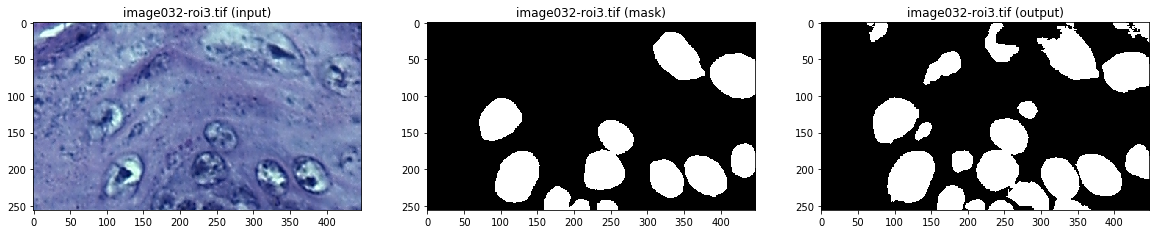

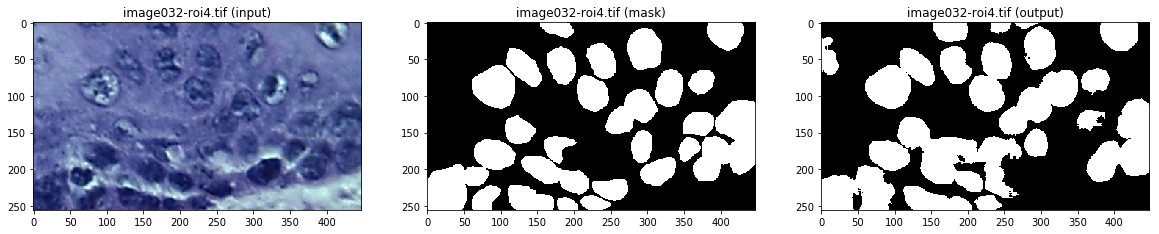

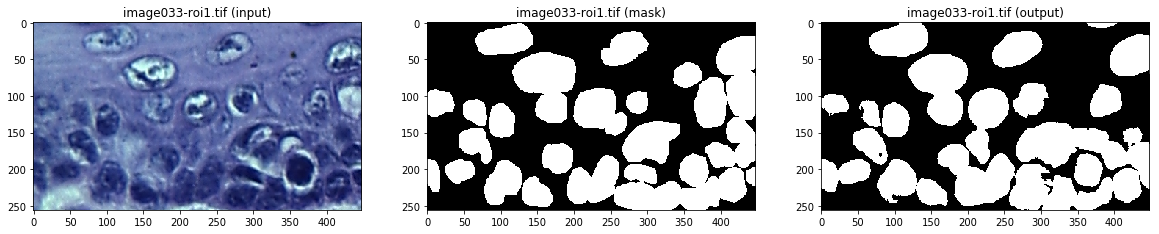

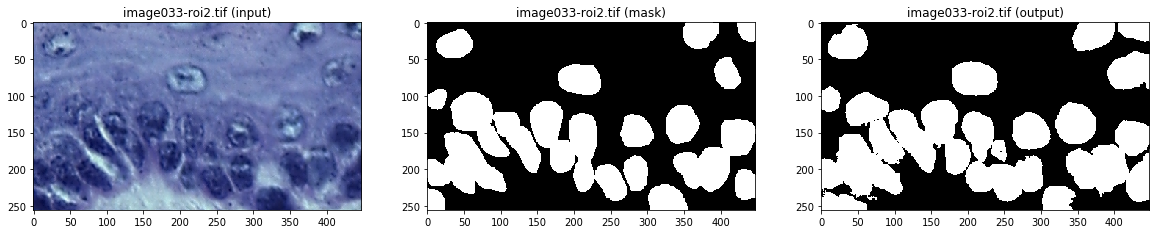

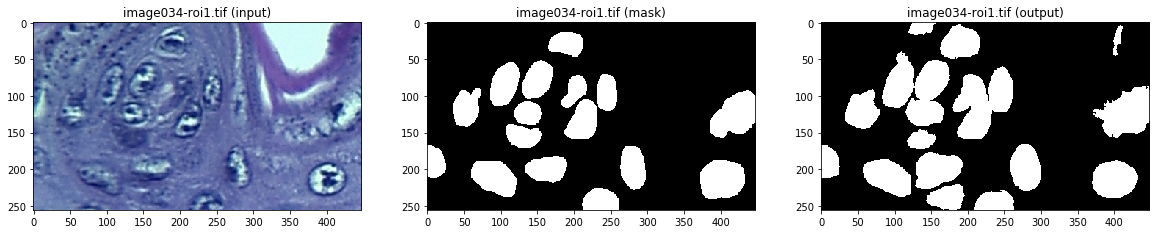

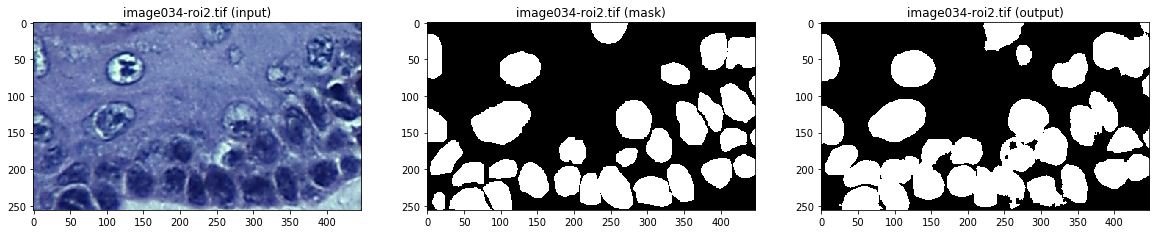

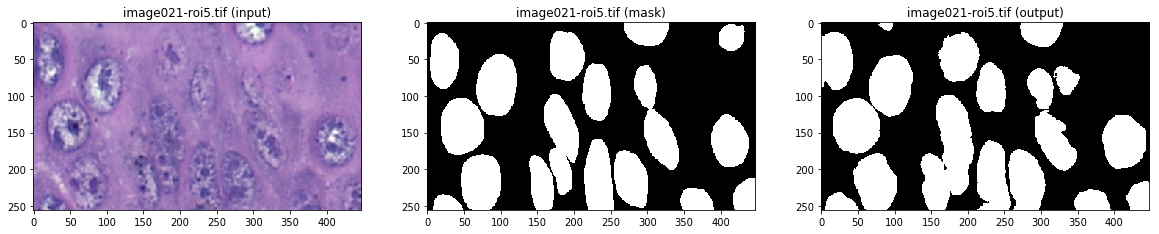

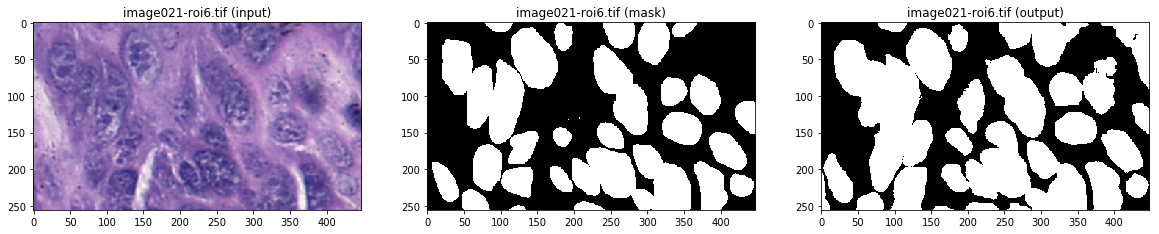

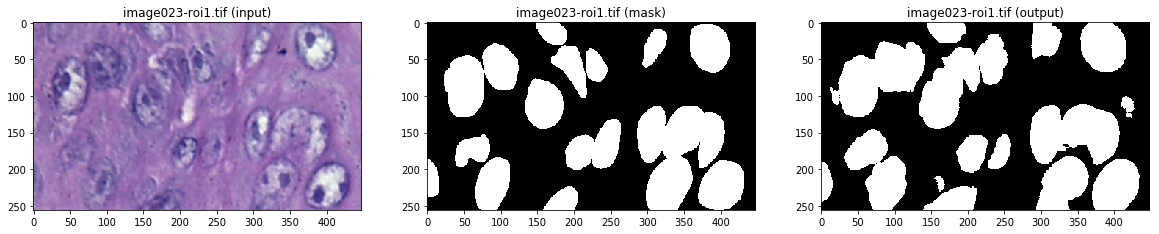

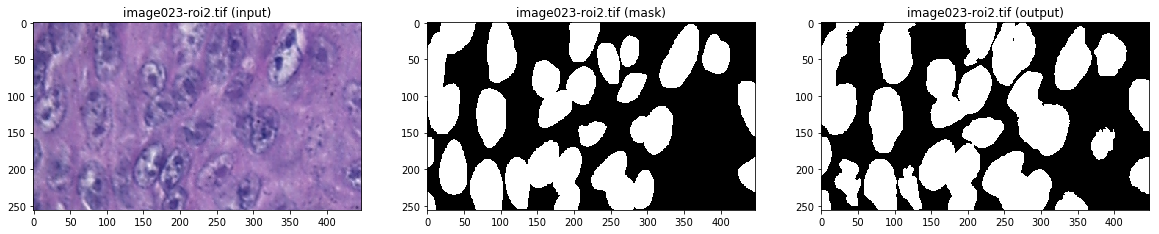

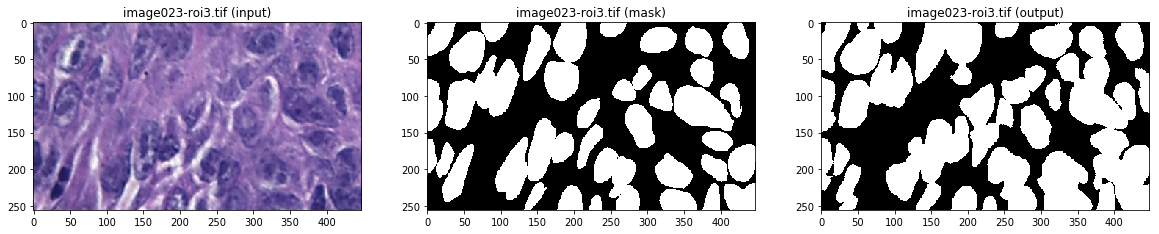

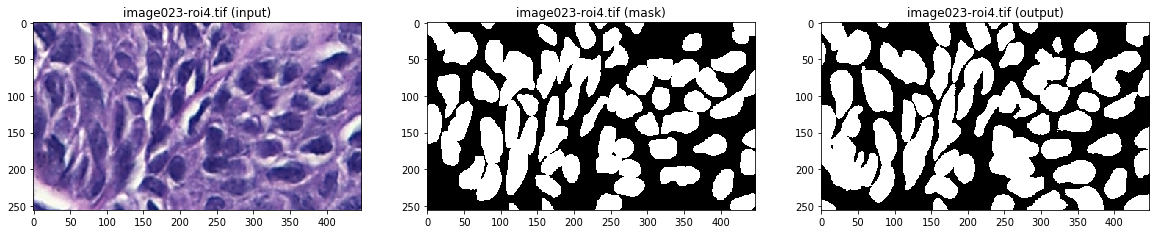

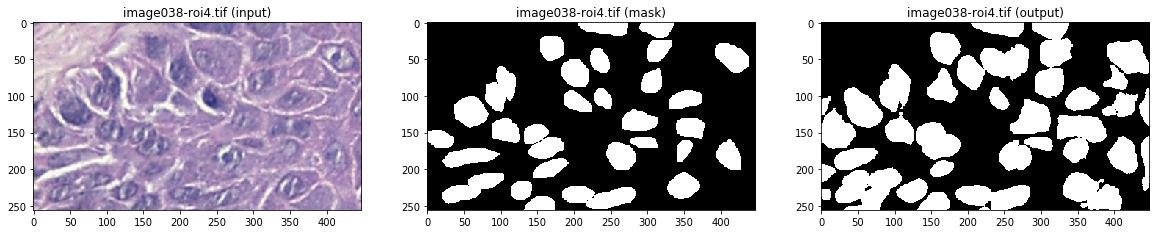

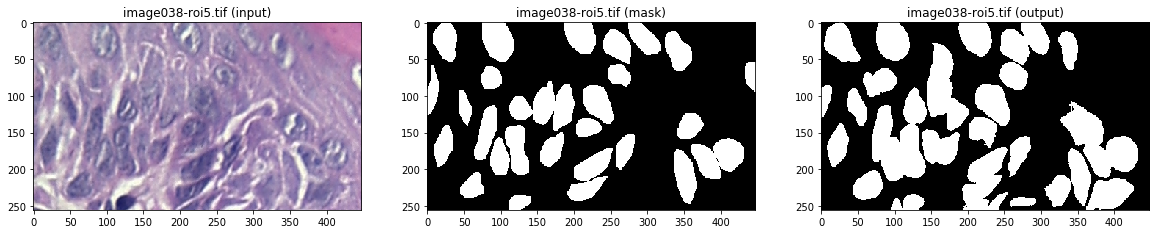

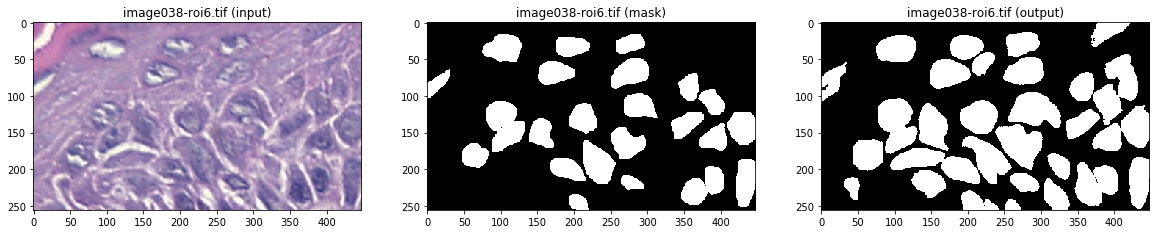

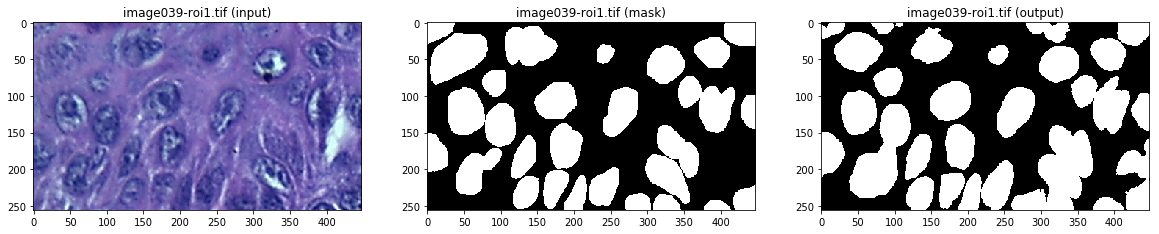

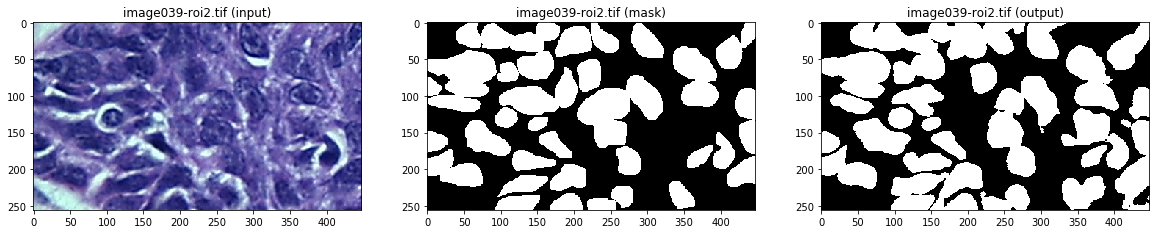

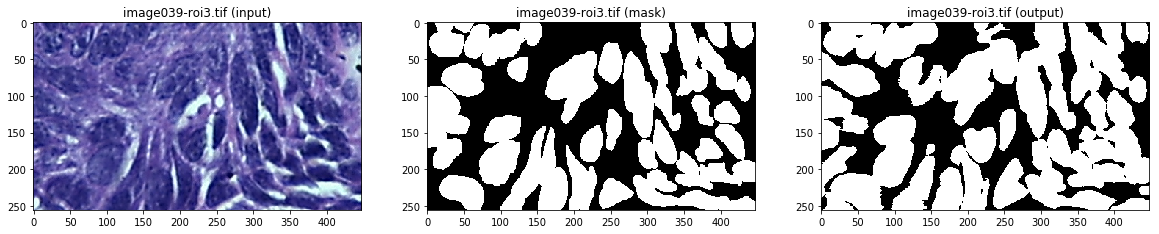

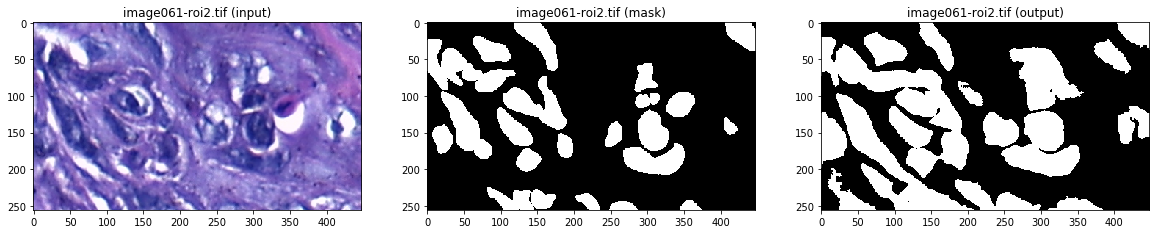

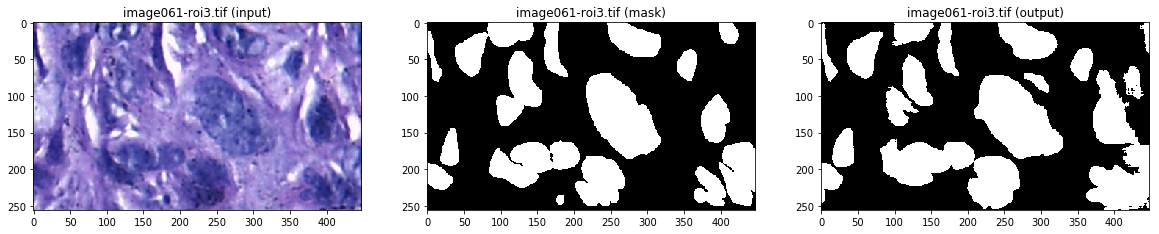

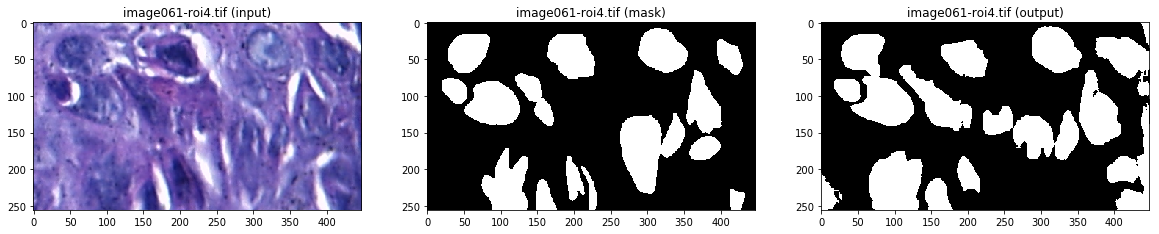

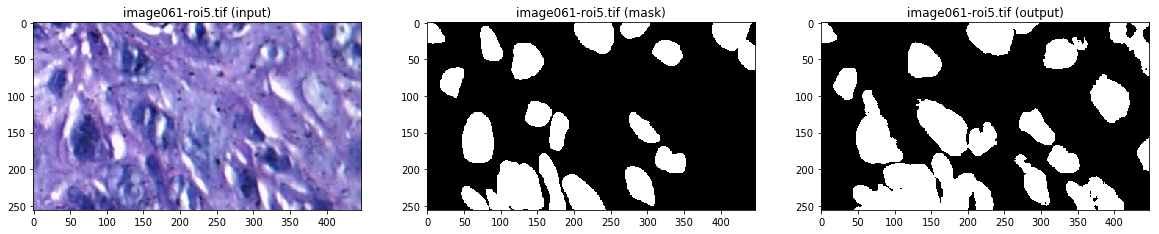

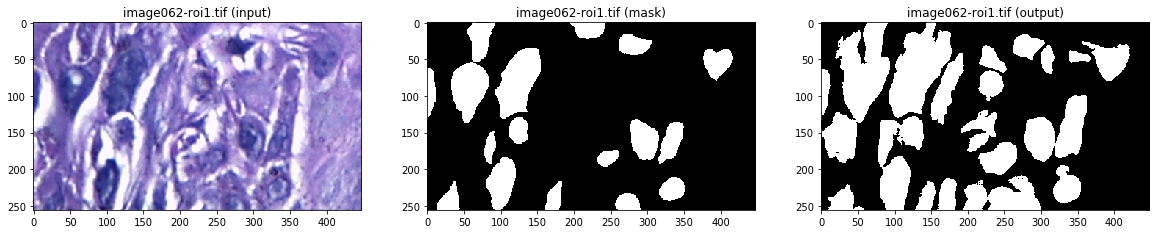

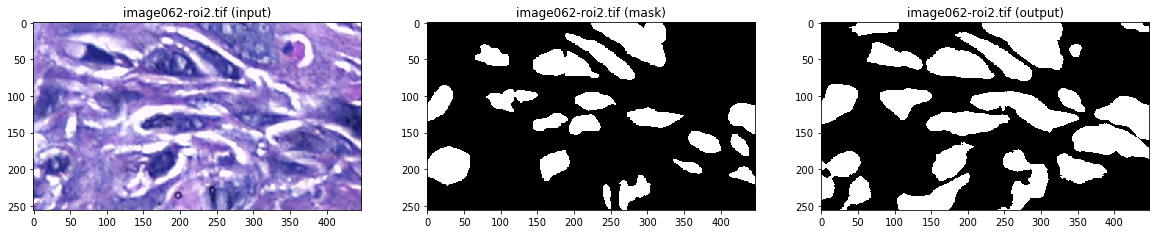

In [1]:
from unet_model import *
from oral_mice_tissues_dataset import *

from torchvision import transforms
from torchvision import utils
from torch.autograd import Variable

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


# Checking for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print()
print('Runing on: {}'.format(device))


# create the datasets
batch_size = 1
color_normalization = "1-original"
dataset_dir = "/home/dalifreire/notebooks/github/histological_oral_mice_tissues/roi"
dataloaders = create_dataloader(method=color_normalization, batch_size=batch_size, dataset_dir=dataset_dir)


# directory to save results
seg_method = "1-unet_based"
results_dir = "results/{}/{}".format(color_normalization, seg_method)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

    
# load the trained model
epoch = 500
model = UNet(in_channels=3, out_channels=1, padding=True).to(device)
model = load_checkpoint(file_path="{}__Dataset-{}__Epoch-{}__Size-448x256.pt".format(model.name(), color_normalization, epoch))


# iterate over test dataset images        
t1 = datetime.now()
print(t1)
for batch_idx, (images, masks, fname, original_size) in enumerate(dataloaders['test']):
    
    t = datetime.now()
    
    X = Variable(images.to(device))
    print('Batch {}: {}/{} images: {} masks: {} {}'.format(
        (batch_idx+1), 
        (batch_idx+1) * len(images), 
        len(dataloaders['test'].dataset),
        images.shape,
        masks.shape,
        datetime.now()))
    
    
    y_hat = model(X).squeeze(0)
    X_numpy = X.cpu().numpy()
    y_hat_numpy = y_hat.detach().cpu().numpy()
    
    
    input_image_filename  = '{}/{} - input.png'.format(results_dir, fname[0][0:-4])
    mask_image_filename   = '{}/{} - mask.png'.format(results_dir, fname[0][0:-4])
    output_image_filename = '{}/{} - output - 1.png'.format(results_dir, fname[0][0:-4])
    output_image_filename_otsu  = '{}/{} - output - 2 - otsu.png'.format(results_dir, fname[0][0:-4])
    output_image_filename_hyst  = '{}/{} - output - 3 - hysteresis.png'.format(results_dir, fname[0][0:-4])
    output_image_filename_basic = '{}/{} - output - 4 - basic.png'.format(results_dir, fname[0][0:-4])
    f, ax = plt.subplots(1, 3, figsize=(20, 20))
    
    
    # save the input image
    input_image = images[0]
    utils.save_image(input_image, input_image_filename)
    ax[0].imshow(input_image.permute(1, 2, 0))
    ax[0].set_title('{} (input)'.format(fname[0]))
    
    # save the mask image
    mask_image = masks[0]
    utils.save_image(mask_image, mask_image_filename)
    ax[1].imshow(mask_image, cmap='gray')
    ax[1].set_title('{} (mask)'.format(fname[0]))
    
    # save the predicted output image
    output_image = y_hat[0].squeeze(0).detach().cpu().numpy()
    output_image_otsu  = otsu_threshold(np_img=output_image)
    output_image_hyst  = hysteresis_threshold(np_img=output_image, low=0.2, high=0.8)
    output_image_basic = basic_threshold(np_img=output_image, threshold=0.2)
    
    utils.save_image(y_hat[0], output_image_filename)
    utils.save_image(TF.to_tensor(np_to_pil(output_image_otsu)), output_image_filename_otsu)
    utils.save_image(TF.to_tensor(np_to_pil(output_image_hyst)), output_image_filename_hyst)
    utils.save_image(TF.to_tensor(np_to_pil(output_image_basic)), output_image_filename_basic)
    
    ax[2].imshow(output_image_hyst, cmap='gray')
    ax[2].set_title('{} (output)'.format(fname[0]))
        

### Qualitative analysis

In [2]:
from torchvision import utils
from torchvision import transforms
from image_utils import *
from experimental_evaluation import *

import os
import csv
import collections

color_norm_methods = ["1-original", "2-khan_et_al", "3-macenko_et_al", "4-tosta_et_al", "5-reinhard_et_al", "6-vahadane_et_al"]
seg_methods = ["1-unet_based", "2-de_oliveira_et_al_(2013)", "3-phoulady_et_al_(2016)", "4-vahadane_and_sethi_(2013)", "5-wienert_et_al_(2012)"]
results_dir = "/home/dalifreire/notebooks/github/dysplastic_oral_tissues_segmentation/results"
#results_dir = "/home/dalifreire/Documents/Doutorado/github/dysplastic_oral_tissues_segmentation/results"

for r, d, f in sorted(os.walk(results_dir)):
    for norm_method in sorted(color_norm_methods):
        if (r.endswith(norm_method)):
            
            print(r)
            for seg_method in sorted(seg_methods):
                
                print("\t{}".format(seg_method))
                seg_method_dir = "{}/{}".format(r, seg_method)
                
                for r_seg, d_seg, f_sef in sorted(os.walk(seg_method_dir)):
                    for file in sorted(f_sef):
                        
                        threshold_type = "output - 2 - otsu.png" if seg_method == "1-unet_based" else "output.png"
                        if file.lower().endswith(threshold_type):
                            
                            input_filename = "{}/{}/{}".format(r, seg_method, file.replace(threshold_type, 'input.png'))
                            mask_filename = "{}/{}/{}".format(r, seg_method, file.replace(threshold_type, 'mask.png'))
                            output_filename = "{}/{}/{}".format(r, seg_method, file)

                            input_image = load_pil_image(input_filename)
                            mask_image = load_pil_image(mask_filename, gray=True)
                            output_image = load_pil_image(output_filename, gray=True)

                            
                            merge_image_output_b = cut_image_by_mask(input_image, output_image, inverse=True)
                            merge_image_mask_b = cut_image_by_mask(input_image, mask_image, inverse=True)

                            merge_image_output_f = cut_image_by_mask(input_image, output_image, inverse=False)
                            merge_image_mask_f = cut_image_by_mask(input_image, mask_image, inverse=False)

                                                        
                            utils.save_image(transforms.ToTensor()(merge_image_output_f), output_filename.replace(".png", "_2.png"))
                            utils.save_image(transforms.ToTensor()(merge_image_mask_f), output_filename.replace(".png", "_3.png"))
                            
                            utils.save_image(transforms.ToTensor()(merge_image_output_b), output_filename.replace(".png", "_4.png"))
                            utils.save_image(transforms.ToTensor()(merge_image_mask_b), output_filename.replace(".png", "_5.png"))


/home/dalifreire/notebooks/github/dysplastic_oral_tissues_segmentation/results/1-original
	1-unet_based


### Quantitative analysis

In [3]:
from torchvision import utils
from image_utils import *
from experimental_evaluation import *

import os
import csv
import collections


color_norm_methods = ["1-original"]
seg_methods = ["1-unet_based"]
results_dir = "/home/dalifreire/notebooks/github/dysplastic_oral_tissues_segmentation/results"
#results_dir = "/home/dalifreire/Documents/Doutorado/github/dysplastic_oral_tissues_segmentation/results"

for r, d, f in sorted(os.walk(results_dir)):
    for norm_method in sorted(color_norm_methods):
        if (r.endswith(norm_method)):
            
            print(r)
            for seg_method in sorted(seg_methods):
                
                print("\t{}".format(seg_method))
                seg_method_dir = "{}/{}".format(r, seg_method)
                
                with open('{}/quantitative_analysis_otsu.csv'.format(seg_method_dir), mode='w') as medidas_file:
                    medidas_writer = csv.writer(medidas_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                    medidas_writer.writerow(['image', 'accuracy', 'precision', 'f1/dice', 'jaccard', 'sensitivity/recall', 'specificity'])
                
                    for r_seg, d_seg, f_sef in sorted(os.walk(seg_method_dir)):
                        for file in sorted(f_sef):
                            
                            threshold_type = "output - 2 - otsu.png" if seg_method == "1-unet_based" else "output.png"
                            if file.lower().endswith(threshold_type):

                                mask_filename = "{}/{}/{}".format(r, seg_method, file.replace(threshold_type, "mask.png"))
                                output_filename = "{}/{}/{}".format(r, seg_method, file)
                                
                                accuracy = pixel_accuracy_score(mask_filename, output_filename)
                                jaccard = jaccard_index_score(mask_filename, output_filename)
                                precision = precision_score(mask_filename, output_filename)
                                recall = recall_score(mask_filename, output_filename)
                                f1 = f1_score(mask_filename, output_filename)
                                sensitivity = sensitivity_score(mask_filename, output_filename)
                                specificity = specificity_score(mask_filename, output_filename)
                                dice = dice_score(mask_filename, output_filename)
                                
                                print(file.replace(" - " + threshold_type, ""))
                                print('\t{}: \t\t{}'.format('accuracy', accuracy))
                                print('\t{}: \t\t{}'.format('precision', precision))
                                print('\t{}: \t\t{}'.format('f1/dice', f1))
                                print('\t{}: \t\t{}'.format('jaccard', jaccard))
                                print('\t{}: \t{}'.format('sensitivity/recall', sensitivity))
                                print('\t{}: \t\t{}'.format('specificity', specificity))
                                print()

                                medidas_writer.writerow([file.replace(" - " + threshold_type, ""), accuracy, precision, f1, jaccard, sensitivity, specificity])

/home/dalifreire/notebooks/github/dysplastic_oral_tissues_segmentation/results/1-original
	1-unet_based
image021-roi5
	accuracy: 		0.9317278180803571
	precision: 		0.9195976331360947
	f1/dice: 		0.9084595959595959
	jaccard: 		0.832272990167727
	sensitivity/recall: 	0.8975881347317839
	specificity: 		0.9524243018402846

image021-roi6
	accuracy: 		0.8722011021205357
	precision: 		0.8365907681403384
	f1/dice: 		0.865634425162491
	jaccard: 		0.7631000484887668
	sensitivity/recall: 	0.8967672086309072
	specificity: 		0.8513539651837524

image023-roi1
	accuracy: 		0.9143240792410714
	precision: 		0.8623969861078409
	f1/dice: 		0.8817256072606466
	jaccard: 		0.7884698183070696
	sensitivity/recall: 	0.9019405043341213
	specificity: 		0.9211123110151188

image023-roi2
	accuracy: 		0.8812691824776786
	precision: 		0.8416412886680558
	f1/dice: 		0.8605287146763901
	jaccard: 		0.7552
	sensitivity/recall: 	0.880283313425955
	specificity: 		0.8819717174130542

image023-roi3
	accuracy: 		0.8605433872